In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 20, 20
plt = mpl.pyplot
import numpy as np

# Film spectral sensitivity curves extraction

Turning graphs from manufacturer's data sheets into useable data.

Some inputs used beziers which may or may not be reliable. Interpolating those data between primary control points is still to-do.

## Tools

### Tokenize SVG path

Courtesy of [StackOverflow](https://codereview.stackexchange.com/a/28565)

In [2]:
import re

COMMANDS = set('MmZzLlHhVvCcSsQqTtAa')
COMMAND_RE = re.compile("([MmZzLlHhVvCcSsQqTtAa])")
FLOAT_RE = re.compile("[-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?")

def _tokenize_path(pathdef):
    for x in COMMAND_RE.split(pathdef):
        if x in COMMANDS:
            yield x
        params = FLOAT_RE.findall(x)
        if len(params) > 0:
            yield params

### Turn SVG path tokens into points relative to a reference origin

In [3]:
def _path_to_points(path, origin, max_x, max_y):
    commands_w_params = []

    current_command = None
    current_parameters = []

    for tkn in _tokenize_path(path):
        if isinstance(tkn, str):
            # reset command and parameters
            current_command = tkn
            current_parameters = []
            continue

        if current_command is None:
            raise ValueError("`tokens` does not start with a command")

        current_parameters = [float(par) for par in tkn]
        commands_w_params.append((current_command, current_parameters))

    points = []
    origin = np.array(origin)
    for cmd in commands_w_params:
        # MOVE PEN
        if cmd[0] == "M":
            p = np.array((cmd[1][0], cmd[1][1])) - origin
            p[1] = max_y - p[1]
            points.append(p)
        # LINE TO
        elif cmd[0] == "L":
            p = np.array((cmd[1][0], -cmd[1][1])) - origin
            points.append(p)
        elif cmd[0] == "l":
            p = points[-1] + np.array((cmd[1][0], -cmd[1][1]))
            points.append(p)
        # HORIZONTAL LINE
        elif cmd[0] == "H":
            p = np.array((cmd[1][0], points[-1][1])) - origin
            points.append(p)
        elif cmd[0] == "h":
            p = points[-1] + np.array((cmd[1][0], 0))
            points.append(p)
        # VERTICAL LINE
        elif cmd[0] == "V":
            p = np.array((points[-1][0], -cmd[1][1])) - origin
            points.append(p)
        elif cmd[0] == "v":
            p = points[-1] + np.array((0, -cmd[1][1]))
            points.append(p)
        # CUBIC BEZIER
        elif cmd[0] == "C":
            # naively handling curves for now - TODO: actually handle beziers
            p = np.array((cmd[1][4], -cmd[1][5])) - origin
            points.append(p)
        elif cmd[0] == "c":
            # naively handling curves for now - TODO: actually handle beziers
            p = points[-1] + np.array((cmd[1][4], -cmd[1][5]))
            points.append(p)
        # TODO: handle more commands
        else:
            raise ValueError(f"unknown command {cmd[0]}")

    return points


### Container for Data

In [4]:
class FilmSpectralData:
    def __init__(
        self,
        yellow_forming_layer_path: str,
        magenta_forming_layer_path: str,
        cyan_forming_layer_path: str,
        origin,
        max_x, min_x_value, max_x_value,
        max_y, min_y_value, max_y_value
    ):
        _yellow_points = _path_to_points(yellow_forming_layer_path, origin, max_x, max_y)
        _magenta_points = _path_to_points(magenta_forming_layer_path, origin, max_x, max_y)
        _cyan_points = _path_to_points(cyan_forming_layer_path, origin, max_x, max_y)


        self.yellow_points = [
            p / (max_x, max_y)
            * (max_x_value - min_x_value, max_y_value - min_y_value)
            + (min_x_value, min_y_value)
            for p in _yellow_points ]

        self.magenta_points = [
            p / (max_x, max_y)
            * (max_x_value - min_x_value, max_y_value - min_y_value)
            + (min_x_value, min_y_value)
            for p in _magenta_points ]

        self.cyan_points = [
            p / (max_x, max_y)
            * (max_x_value - min_x_value, max_y_value - min_y_value)
            + (min_x_value, min_y_value)
            for p in _cyan_points ]

        # print(f"yellow samples: {len(self.yellow_points)}")
        # print(f"magenta samples: {len(self.magenta_points)}")
        # print(f"cyan samples: {len(self.cyan_points)}")

## Converting SVG paths into data

The paths were extracted from the manufacturer-provided data sheets by turning parts of those PDFs into SVGs with Adobe Illustrator. Illustrator's treatment of the file may or may not have added additional error to the original data.

The sources of the data sheets are specified above the sections for their respective films.

In [5]:
# Source: https://imaging.kodakalaris.com/sites/default/files/files/products/e4046_ektar_100.pdf
ektar_100 = FilmSpectralData(
    "M117.58,477.67l0.49-2.45l0.49-2.45l0.26-1.22l0.27-1.28c1.68-9.01,2.83-18.14,4.38-27.18l0.13-0.64l0.27-1.22   c0.71-3.1,1.91-7.95,3.72-10.59l0.27-0.32l0.22-0.21l0.27-0.21l0.22-0.11c3.18-1.18,4.14,1.97,5.54,1.44l0.26-0.11l0.22-0.16   l0.53-0.27c0.82-0.52,2.52-0.8,3.5-1.38l1.02-0.53l0.27-0.16l0.22-0.21l0.53-0.43l0.22-0.16l0.27-0.16l0.22-0.11h0.26l0.27,0.05   l0.22,0.16l0.27,0.21l0.22,0.27l0.53,0.58l0.22,0.26l0.27,0.21c2.6,2.91,4.39,1.66,6.51-1.06l0.49-0.69l0.53-0.74   c1.71-1.95,2.1-4.47,4.08-0.74l0.26,0.59l0.18,0.69l0.13,0.59c3.84,25.05,4.26,50.49,6.86,75.68l0.49,5.64l0.27,2.87l0.26,2.87",
    "M123.6,490.43l0.27-0.64l0.22-0.69l0.49-1.38l0.27-0.64l0.26-0.64c0.45-1.07,1.2-2.48,2.48-2.66h0.27   l0.22,0.05c1.78,1.25,3.24,2.04,4.56,3.83l0.49,0.69l0.49,0.64l0.49,0.64l0.49,0.69c1.99,2.61,2.85,2.61,4.56,5.74l0.49,0.85   l0.49,0.8c1.17,1.64,2.43,4.87,5,4.15l0.22-0.05h0.26l0.49,0.05l0.53,0.16l0.53,0.11l0.49,0.05h0.49l0.53-0.11l0.49-0.05l0.49-0.05   l0.97,0.05l1.02,0.05l0.27,0.06l0.22,0.05l0.49,0.21l0.27,0.05l0.27,0.05l0.22-0.11c1.19-0.55,2.47-4.46,2.79-5.64l0.27-0.9   l0.27-0.91l0.22-1.01c2.17-8.57,2.22-17.77,6.29-25.8l0.49-1.01l0.49-1.01l0.53-0.96l0.49-0.9l0.49-0.8l0.49-0.69l0.49-0.53   c2.37-2.36,3.07-2.49,5.05-5.58l0.49-0.64l0.49-0.53c2.05-2.48,3.39-6.11,5.54-8.88l0.53-0.69l0.98-1.22l0.49-0.53l0.49-0.53   l0.53-0.53l0.49-0.53l0.27-0.32l0.22-0.37l0.49-0.74l0.27-0.37l0.26-0.32l0.22-0.21l0.27-0.16l0.26-0.05h0.22l0.27,0.11   c1.57,0.51,2.14,2.31,3.54,2.98h0.71l0.53-0.05h0.22l0.27,0.05l0.49,0.21l0.49,0.27c1.44,0.96,1.78,2.81,2.57,4.31l0.22,0.53   l0.26,0.43l0.18,0.16l0.27,0.11l0.26,0.11l0.31,0.11l0.27,0.16l0.26,0.16l0.27,0.32l0.09,0.21l0.09,0.21l0.26,0.9l0.09,0.53   l0.13,0.58l0.13,0.58l0.13,0.64c2.29,13.86,2.77,28.62,3.99,42.6l0.26,3.56l0.49,7.18l0.27,3.56l0.27,3.56",
    "M187.73,523.14l0.49-1.33c0.64-1.77,2.03-5.75,3.5-7.07l0.09-0.05l0.09,0.05l0.22,0.05l0.31,0.16l0.31,0.16   l0.31,0.16h0.44l0.09-0.11l0.09-0.11l0.09-0.21l0.13-0.48l0.13-0.64l0.09-0.64l0.13-0.75l0.13-0.85l0.13-0.85   c0.59-4.26,0.98-8.55,1.51-12.82l0.09-1.17l0.13-1.28l0.27-2.55c1.02-10.19,1.83-21.07,3.72-31.12l0.27-1.06l0.26-0.9l0.27-0.85   l0.27-0.74l0.49-1.49c0.73-2.18,1.98-4.27,2.97-6.38l0.53-0.9l0.49-0.96c0.61-1.06,1.29-3.32,2.26-4.15l0.22-0.16l0.26-0.16   l0.8-0.16l0.49-0.05h0.49l0.53,0.11l0.49,0.11l0.22,0.05l0.27-0.05l0.26-0.05l0.22-0.16l0.49-0.27l0.53-0.32   c1.43-0.92,2.63-1.17,4.03-2.5l0.49-0.53l0.27-0.32l0.22-0.32l0.49-0.8l0.53-0.8l0.49-0.74l0.49-0.69l0.49-0.64   c1.47-1.89,2.87-3.06,4.07-5.16l0.22-0.37l0.27-0.37c0.44-0.65,1.27-0.96,1.99-0.58l0.22,0.16l0.27,0.26l0.27,0.32   c3.24,5.76,3.5,12.84,4.52,19.26l0.26,2.13l0.22,2.13l0.27,2.07l0.13,1.01c1.03,8.13,2.55,16.9,4.83,24.79l0.26,0.69l0.27,0.69   c2.43,7.39,3.22,16.78,3.99,24.57l0.27,2.66l0.27,2.66l0.22,2.61l0.26,2.55",
    np.array((65.45, 381.34)),
    200.46, 250, 750,
    151.48, 0, 3
)

# Source: https://imaging.kodakalaris.com/sites/default/files/files/products/e4051_portra_160.pdf
portra_160 = FilmSpectralData(
    "M117.14,447.54c1.34-5.12,2.67-10,4.01-15.35c1.34-5.35,2.67-13.82,4.01-16.74c1-2.18,3.01-0.54,4.01-0.74   c1.34-0.26,2.67-0.95,4.01-0.86c1.34,0.09,2.67,1.58,4.01,1.42c1.34-0.15,2.67-2.32,4.01-2.36c1.34-0.03,2.68,2.25,4.01,2.17   c1.34-0.08,2.67-1.74,4.01-2.64c1.34-0.9,2.67-4.37,4.01-2.77c1.18,1.39,2.84,5.84,4.01,12.33c1.34,7.38,2.67,23.62,4.01,31.96   c1.33,8.34,2.67,12.66,4.01,18.07c1.34,5.41,3.34,11.98,4.01,14.38",
    "M121.16,460.62c0.67-2.28,2.67-11.61,4.01-13.68c1.29-2,2.72,0.83,4.01,1.24c1.33,0.42,2.67,0.34,4.01,1.28   c1.34,0.94,2.67,3.58,4.01,4.37c1.34,0.78,2.67-0.1,4.01,0.33c1.33,0.43,2.67,1.98,4.01,2.25c1.34,0.26,2.67-0.34,4.01-0.66   c1.34-0.33,2.67,0.09,4.01-1.28c1.34-1.37,2.67-4.68,4.01-6.96c1.34-2.27,2.67-4.61,4.01-6.69c1.33-2.08,2.67-4.35,4.01-5.79   c1.34-1.45,2.67-1.88,4.01-2.89c1.34-1.01,2.67-2.06,4.01-3.2c1.34-1.14,2.67-2.25,4.01-3.65c1.34-1.39,2.67-3.26,4.01-4.73   c1.34-1.47,2.67-3.97,4.01-4.1c1.34-0.13,2.67,2.07,4.01,3.33c1.34,1.27,2.67,1.55,4.01,4.25c1.27,2.58,2.73,5.69,4.01,11.97   c1.34,6.58,3.34,22.96,4.01,27.55",
    "M161.23,484.76c0.67-0.23,2.67-0.48,4.01-1.41c1.34-0.93,2.68-2.86,4.01-4.18c1.34-1.31,2.67-2.96,4.01-3.72   c1.34-0.76,2.67-0.77,4.01-0.82c1.34-0.04,2.67,1.17,4.01,0.56c1.34-0.6,2.67-2.04,4.01-4.17c1.34-2.13,2.67-5.78,4.01-8.59   c1.34-2.81,2.68-4.24,4.01-8.28c1.33-4.04,2.67-11.48,4.01-15.99c1.34-4.5,2.67-8.05,4.01-11.04c1.34-2.98,2.68-4.91,4.01-6.88   c1.34-1.97,2.67-3.66,4.01-4.92c1.33-1.26,2.67-1.99,4.01-2.64c1.34-0.65,2.68-2.14,4.01-1.27c1.04,0.68,2.97,2.6,4.01,6.45   c1.34,4.92,2.67,17.9,4.01,23.1c1.14,4.43,2.87,3.58,4.01,8.13c1.34,5.34,3.34,19.94,4.01,23.92",
    np.array((65.01, 372.77)),
    200.48, 250, 750,
    151.59, 0, 3
)

# Source: https://imaging.kodakalaris.com/sites/default/files/files/products/e4050_portra_400.pdf
portra_400 = FilmSpectralData(
    "M_240.32,394.23c1.33-5.79,2.67-12.12,4.01-17.38c1.34-5.26,2.67-11.58,4.01-14.18  c1.12-2.18,2.89-1.49,4.01-1.45c1.33,0.05,2.67,1.5,4.01,1.74c1.34,0.24,2.67-0.28,4.01-0.28c1.34,0,2.67-0.04,4.01,0.29  c1.33,0.33,2.67,1.54,4.01,1.7c1.34,0.15,2.67-0.31,4.01-0.78c1.34-0.47,2.67-3.34,4.01-2.02c1.24,1.22,2.77,4.59,4.01,9.91  c1.33,5.73,2.67,17.43,4.01,24.5c1.34,7.07,2.67,12.27,4.01,17.91c1.34,5.65,2.67,10.14,4.01,15.95c1.33,5.81,3.34,15.76,4.01,18.91",
    "M244.34,412.82c0.67-1.88,2.67-9.4,4.01-11.28c1.33-1.87,2.68-0.5,4.01,0c1.33,0.5,2.67,2.09,4.01,3.01  c1.34,0.91,2.67,1.72,4.01,2.48c1.34,0.76,2.67,1.65,4.01,2.1c1.34,0.45,2.67,0.63,4.01,0.59c1.33-0.05,2.67-0.42,4.01-0.86  c1.34-0.43,2.67,0.06,4.01-1.74c1.34-1.8,2.67-5.97,4.01-9.07c1.33-3.11,2.67-6.97,4.01-9.54c1.33-2.58,2.67-4.43,4.01-5.92  c1.34-1.49,2.67-1.94,4.01-3.02c1.34-1.08,2.67-2.27,4.01-3.48c1.34-1.22,2.67-2.3,4.01-3.8c1.34-1.5,2.68-3.79,4.01-5.23  c1.34-1.44,2.67-3.28,4.01-3.42c1.33-0.14,2.67,1.42,4.01,2.59c1.33,1.17,2.67,2.65,4.01,4.41c1.02,1.34,2.99,2.4,4.01,6.15  c1.34,4.92,2.67,13.75,4.01,23.36c1.34,9.61,3.34,28.55,4.01,34.27",
    "M284.45,445.09c0.67-0.9,2.67-3.57,4.01-5.39c1.33-1.82,2.67-3.92,4.01-5.51c1.34-1.59,2.67-3.08,4.01-4.01  c1.34-0.93,2.67-1.55,4.01-1.58c1.34-0.03,2.67,1.24,4.01,1.39c1.33,0.14,2.67,0.98,4.01-0.54c1.34-1.52,2.67-5.44,4.01-8.57  c1.34-3.13,2.67-5.95,4.01-10.18c1.33-4.24,2.67-10.68,4.01-15.23c1.34-4.55,2.67-9.16,4.01-12.09c1.33-2.94,2.68-3.79,4.01-5.53  c1.34-1.74,2.67-3.56,4.01-4.93c1.34-1.36,2.67-2.56,4.01-3.27c1.34-0.7,2.67-0.7,4.01-0.94c1.34-0.24,2.67,0.82,4.01-0.5  c1.33-1.32,2.67-6.84,4.01-7.4c0.74-0.32,3.27,0.94,4.01,3.99c1.33,5.52,2.67,17.72,4.01,29.12c1.34,11.39,3.34,32.7,4.01,39.24",
    np.array((188.21, 308.09)),
    200.51, 250, 750,
    151.5, 0, 4
)

# Source: https://imaging.kodakalaris.com/sites/default/files/files/products/e4040_portra_800.pdf
portra_800 = FilmSpectralData(
    "M389.63,442.95l0.47-2.18l0.52-2.18l0.47-2.18l0.26-1.01l0.26-1.01l0.26-0.96l0.26-0.96l0.47-1.76l0.52-1.76   l0.52-1.76l0.52-1.76l0.47-1.76l0.26-0.85l0.21-0.96l0.26-0.96l0.26-1.01l0.52-2.18l0.47-2.35l0.52-2.45l0.52-2.61l0.26-1.38   c0.62-3.29,0.95-6.6,1.64-9.86l0.13-0.64l0.26-1.12c0.4-1.8,0.85-3.59,1.46-5.33l0.26-0.64l0.26-0.59   c0.33-0.71,0.73-1.39,1.25-1.97l0.52-0.48l0.26-0.21l0.26-0.16l0.52-0.21l0.47-0.11l0.52-0.05l0.52,0.05l0.47,0.16l0.48,0.21   l0.52,0.27l0.26,0.16l0.26,0.21l0.47,0.43l0.52,0.43l0.26,0.16l0.26,0.11l0.52,0.11l0.47-0.05l0.47-0.05h0.52l0.52,0.11l0.47,0.16   l1.03,0.37l1.03,0.43l0.99,0.48l0.52,0.21l0.47,0.16l0.47,0.21l0.52,0.27l0.26,0.16l0.26,0.21l0.47,0.53l0.52,0.43l0.26,0.21   l0.26,0.16l0.52,0.21l0.47,0.11l0.47,0.05h0.52l0.52-0.11l0.47-0.16l0.52-0.21l0.52-0.16l0.52-0.11l0.52-0.05l0.47-0.11l0.26-0.11   l0.26-0.11l0.26-0.16l0.26-0.21l0.47-0.43l0.47-0.53l0.52-0.48l0.52-0.53l0.47-0.53l0.26-0.27l0.26-0.27l0.26-0.16l0.26-0.16   l0.21-0.11c0.6-0.26,1.22-0.57,1.68,0.11l0.09,0.16l0.13,0.27c0.78,2.11,1.1,4.6,1.64,6.82l0.26,1.17l0.26,1.17   c0.56,2.6,0.99,5.18,1.51,7.78l0.26,1.28l0.52,2.45l0.47,2.45l0.47,2.34l0.52,2.29l0.26,1.07c0.52,1.95,1.05,3.95,1.51,5.91   l0.26,1.17l0.26,1.33l0.26,1.39l0.26,1.44l0.26,1.55l0.47,3.14l0.52,3.14l0.26,1.6l0.26,1.6l0.47,3.3l0.47,3.3l0.26,1.65l0.26,1.54   l0.52,3.14c0.4,2.45,0.74,4.86,1.25,7.3l0.26,1.28l0.13,0.58c0.46,2.03,1.05,3.91,1.59,5.92l0.26,1.06l0.26,1.17   c0.58,2.58,0.91,5.19,1.51,7.78l0.26,1.17l0.26,1.07c0.48,1.89,0.94,3.71,1.51,5.59l0.26,0.91",
    "M397.64,455.04l0.26-1.6c0.59-3.39,0.9-6.82,1.64-10.18l0.13-0.53l0.22-0.8c0.42-1.05,0.79-2.01,1.55-2.88   l0.21-0.32l0.52-0.64l0.47-0.48l0.26-0.16l0.26-0.16l0.26-0.11l0.26-0.05h0.26l0.26,0.05l0.26,0.11l0.26,0.16l0.47,0.37l0.52,0.32   l0.99,0.58l0.99,0.64l0.99,0.58l1.03,0.54l0.99,0.58l0.47,0.32l0.52,0.21l0.52,0.16l0.47,0.05l0.52,0.11l0.52,0.16l0.52,0.27   l0.52,0.32l0.47,0.37l0.52,0.37l0.26,0.21c0.53,0.51,0.83,1.07,1.46,1.54l0.26,0.16l0.26,0.11l0.26,0.05l0.47-0.05l0.52-0.05   l0.52-0.11l0.52-0.05l0.47-0.11l0.47-0.11l0.52-0.21l0.52-0.32l0.47-0.32l0.52-0.42l0.52-0.37l0.52-0.37l0.52-0.43l0.47-0.32   l0.26-0.16l0.26-0.11l0.52-0.11l0.47-0.05l0.47,0.05l0.52,0.05l0.26,0.05c0.57,0.19,0.83,0.59,1.51,0.53l0.26-0.05l0.22-0.11   c0.69-0.44,1.26-1.09,1.55-1.86l0.21-0.59l0.26-0.91c0.68-2.64,1.05-5.51,1.51-8.21l0.26-1.76l0.13-0.96   c0.71-5.4,0.93-10.86,1.77-16.25l0.13-0.64l0.04-0.21c0.64-0.95,0.88-0.48,1.77-0.69l0.17-0.11l0.26-0.42   c0.64-1.2,0.91-2.5,1.51-3.79l0.26-0.53l0.52-0.96l0.52-0.9l0.47-0.8l0.26-0.32l0.26-0.32l0.26-0.21l0.26-0.21l0.21-0.11l0.26-0.11   l0.47-0.16l0.26-0.05l0.26-0.16l0.99-0.69l1.03-0.85l0.52-0.48l0.47-0.53l0.47-0.59l0.52-0.48l0.52-0.43l0.47-0.37l0.52-0.43   l0.52-0.43l0.52-0.53l0.52-0.59l0.99-1.23l0.52-0.69l0.47-0.69l0.47-0.69l0.52-0.69l0.52-0.64l0.48-0.53l1.03-1.17l0.99-1.17   l0.99-1.23l0.26-0.32c0.52-0.75,0.83-1.37,1.51-2.03l0.26-0.21l0.26-0.16l0.26-0.11l0.26-0.05h0.73l0.52,0.05l0.52,0.11l0.47,0.16   l0.47,0.21l0.52,0.27l0.52,0.21l0.47,0.27l0.52,0.27l0.26,0.21l0.26,0.21l0.52,0.53l0.47,0.64l0.47,0.74l0.52,0.8l0.26,0.43   c0.52,1.03,0.87,2.06,1.51,3.04l0.26,0.32l0.13,0.11l0.13,0.05l0.21,0.11l0.26-0.05h0.3l0.26-0.05l0.26,0.05l0.21,0.11l0.13,0.16   l0.13,0.16l0.26,0.43c0.68,1.5,1.07,2.88,1.46,4.48l0.26,1.06l0.26,1.12c0.62,2.82,1.03,5.78,1.51,8.63l0.26,1.7l0.26,1.76   c0.55,4.06,1.02,8.13,1.46,12.2l0.26,2.34l0.13,1.23c0.68,6.42,1.1,12.86,1.77,19.29l0.13,1.28l0.52,5.12   c0.45,3.98,0.75,7.96,1.25,11.93l0.26,2.13l0.26,2.03c0.41,3.54,1.01,6.98,1.46,10.49l0.26,1.76",
    "M437.79,480.3l0.52-0.8l0.47-0.85l0.52-0.85l0.26-0.32l0.26-0.32l0.26-0.27c0.47-0.36,1.08-0.47,1.51-0.9   l0.26-0.27l0.26-0.37c0.56-0.89,0.96-2.05,1.46-2.93l0.26-0.48l0.52-0.85l0.47-0.75l0.52-0.8l0.52-0.85l0.26-0.48l0.26-0.53   l0.47-1.17l0.47-1.12l0.26-0.48l0.26-0.48l0.52-0.8l0.47-0.75l0.52-0.64l0.52-0.53l0.51-0.43l0.52-0.37l0.47-0.27l0.52-0.21   l0.52-0.16l0.47-0.05l0.47-0.05l0.52-0.05l0.99-0.11l1.03-0.16l0.99-0.27l0.99-0.27l0.52-0.05l0.47-0.05h0.26l0.26-0.11l0.26-0.11   l0.26-0.16l0.26-0.21l0.26-0.27l0.52-0.64l0.48-0.8l0.52-0.91l0.26-0.53c0.54-1.22,0.95-2.62,1.46-3.84l0.26-0.59l0.26-0.53   l0.26-0.48l0.47-0.96l0.52-0.91l0.52-0.96l0.26-0.53c0.51-1.2,0.87-2.46,1.46-3.62l0.26-0.37l0.17-0.16h1.12l0.3-0.05l0.13-0.11   l0.13-0.1l0.09-0.16l0.09-0.21l0.13-0.43c0.87-3.31,1.11-6.76,1.77-10.12l0.13-0.69l0.26-1.33l0.26-1.28l0.95-5.01l0.52-2.56   l0.26-1.33c0.52-2.77,0.9-5.5,1.51-8.26l0.26-1.12l0.26-1.07c0.41-1.67,0.84-3.34,1.47-4.95l0.26-0.59l0.26-0.48   c0.5-0.92,0.84-1.03,1.51-1.71l0.26-0.32l0.52-0.74l0.52-0.8l0.47-0.85l0.52-0.75l0.52-0.69l0.47-0.69l0.47-0.64l0.52-0.53   l0.52-0.43l0.47-0.27l0.52-0.27l0.52-0.21l0.52-0.16l0.52-0.16l0.48-0.16l0.52-0.21l0.52-0.37l0.47-0.43l0.47-0.48l0.52-0.43   l0.52-0.37l0.47-0.32l1.04-0.64l0.52-0.27l0.47-0.27l0.48-0.27l0.26-0.21l0.26-0.27l0.26-0.32c0.62-0.84,0.83-1.59,1.51-2.56   l0.26-0.37l0.52-0.59l0.52-0.48l0.48-0.48l0.52-0.48l0.51-0.53l0.48-0.59l0.47-0.53l0.52-0.48l0.52-0.43l0.47-0.43l0.26-0.16   l0.26-0.16l0.52-0.11l0.26,0.05l0.26,0.16l0.21,0.21l0.26,0.27l0.26,0.27l0.22,0.21l0.26,0.11h0.26l0.13-0.05   c0.58-0.78,0.77-1.82,1.42-2.56l0.13-0.05l0.09,0.05l0.13,0.11l0.13,0.21l0.13,0.37c0.91,3.66,1.06,7.49,1.77,11.19l0.13,0.64   l0.26,1.17c0.42,1.79,0.91,3.47,1.47,5.22l0.26,0.85l0.26,0.85l0.26,0.8l0.47,1.54l0.52,1.6l0.26,0.85l0.26,0.85l0.26,0.9   l0.26,0.96l0.47,1.97l0.47,2.02l0.52,2.02l0.99,3.94l1.03,3.94l0.26,0.96c0.68,2.1,1.22,4.23,1.64,6.39l0.13,0.75l0.13,0.8   c0.67,4.35,1.1,8.74,1.59,13.11l0.26,2.29l0.13,1.17c0.67,5.95,1.09,11.9,1.77,17.85l0.13,1.17l0.26,2.24   c0.5,4.06,0.95,8.09,1.51,12.15l0.26,2.03",
    np.array((341.43, 338.45)),
    200.77, 250, 750,
    151.7, 0, 4
)

# Source: https://imaging.kodakalaris.com/sites/default/files/files/resources/E7022_Gold_200.pdf
# The Gold 200 data sheet is a little odd. I'm still working on getting the data into a useable format.
# gold_200 = FilmSpectralData(
#     "TODO",
#     "TODO",
#     "TODO",
#     np.array((188.21, 308.09)),
#     200.51, 250, 750,
#     151.5, 0, 4
# )

# Source: http://apps.kodakmoments.com/wp-content/uploads/2017/07/E7023_max_400.pdf
ultra_max_400 = FilmSpectralData(
    "M114.1,500.6l0.52-1.22l0.52-1.23l0.22-0.64l0.26-0.64l0.26-0.75l0.26-0.75l0.26-0.85   c0.56-1.91,0.92-3.96,1.47-5.87l0.26-0.91l0.52-1.71l0.47-1.65l0.52-1.6l0.52-1.55l0.26-0.75l0.26-0.75l0.48-1.44l0.47-1.49   l0.26-0.8l0.26-0.85l0.52-1.81l0.47-1.87l0.26-1.01l0.26-1.07l0.26-1.07l0.26-1.17l0.13-0.59c0.69-3.24,1.06-6.48,1.77-9.71   l0.13-0.53l0.26-1.01c0.39-1.61,0.86-3.1,1.46-4.64l0.26-0.59l0.26-0.53c0.36-0.72,0.7-1.44,1.25-2.03l0.52-0.59l0.26-0.21   l0.26-0.21l0.52-0.32l0.47-0.16l0.52-0.05h0.26l0.26,0.05l0.47,0.21l0.47,0.27l0.52,0.21l0.99,0.37l0.52,0.16l0.52,0.11h0.99   l0.47-0.06l0.52-0.05h0.99l1.04,0.05h1.03l0.99-0.11l0.26-0.05c0.73-0.33,0.73-0.33,1.47-0.48l0.26,0.05l0.26,0.11   c0.65,0.32,0.84,0.93,1.51,1.39l0.26,0.21l0.52,0.37l0.48,0.37l0.47,0.32l0.52,0.27l0.52,0.16l0.47,0.05h1.04h1.03l0.47-0.11   l0.26-0.11l0.26-0.11l0.26-0.16l0.26-0.21l0.47-0.53l0.48-0.59l0.52-0.59l0.26-0.32c0.54-0.61,0.84-1.43,1.51-1.92l0.26-0.11   l0.22-0.05h0.21l0.26,0.05l0.3,0.11l0.3,0.16l0.26,0.21l0.22,0.32l0.22,0.43l0.13,0.37c0.79,2.32,1.11,5.15,1.64,7.58l0.26,1.39   l0.26,1.49c0.6,3.34,0.95,6.69,1.51,10.03l0.26,1.55l0.26,1.44c0.47,2.69,0.94,5.38,1.46,8.06l0.26,1.33l0.52,2.72l0.47,2.67   l0.26,1.39l0.26,1.44l0.26,1.44l0.26,1.49l0.26,1.6c0.59,3.42,0.95,6.83,1.51,10.24l0.26,1.55l0.52,2.94   c0.32,2.18,0.78,4.49,1.21,6.67l0.26,1.17l0.26,1.12c0.49,1.9,0.94,3.72,1.51,5.6l0.26,0.96l0.99,3.95l0.47,1.97l0.52,2.08   l0.26,1.07l0.26,1.12l0.47,2.24l0.52,2.24l0.26,1.07l0.26,1.02l0.26,0.96l0.26,0.96l0.48,1.76l0.52,1.71l0.52,1.76",
    "M124.14,517.46l0.26-1.07c0.56-2.11,0.91-4.22,1.51-6.29l0.26-0.85l0.26-0.8c0.46-1.32,0.78-2.29,1.47-3.52   l0.26-0.37l0.26-0.32c0.65-0.52,0.43-0.49,1.25-0.64h0.52l0.26,0.05l0.26,0.11l0.26,0.16l0.26,0.16l0.47,0.43l0.52,0.43l0.52,0.43   l0.47,0.54l0.47,0.48l0.52,0.43l0.52,0.32l0.47,0.21l0.52,0.21l0.52,0.27l0.99,0.64l0.99,0.69l2.03,1.39l1.03,0.69l0.99,0.75   l0.52,0.43l0.47,0.43l0.47,0.43l0.52,0.37l0.52,0.27l0.47,0.21l0.52,0.16l0.52,0.05h0.52l0.48-0.11l0.48-0.16l0.52-0.21l0.52-0.21   l0.47-0.32l0.52-0.27l0.52-0.27l1.03-0.43l0.99-0.48l0.52-0.27l0.47-0.32l0.47-0.32l0.52-0.21l0.26-0.05   c0.54-0.17,0.9,0.19,1.51-0.16l0.26-0.16l0.22-0.21c0.73-0.55,1.18-1.37,1.55-2.19l0.22-0.64l0.26-0.85   c0.66-2.42,1.03-5.05,1.51-7.52l0.26-1.44l0.13-0.75c0.69-4.09,1.04-8.2,1.77-12.27l0.13-0.69l0.13-0.64   c0.38-1.83,0.79-3.3,1.34-5.07l0.52-1.44l0.26-0.69l0.26-0.69l0.26-0.59l0.21-0.59l0.52-1.12l0.52-1.07l0.52-1.12l0.52-1.07   l0.22-0.53l0.26-0.43l0.26-0.48l0.26-0.37l0.26-0.32l0.26-0.27l0.21-0.27l0.26-0.16l0.47-0.37l0.52-0.43l0.99-0.96l0.52-0.48   l0.52-0.53l0.52-0.59l0.47-0.69l0.48-0.64l0.52-0.64l0.52-0.59l0.47-0.53l0.52-0.54l0.52-0.64l0.52-0.69l0.52-0.8l0.47-0.75   l0.52-0.75l0.99-1.39l0.99-1.28l0.52-0.59l0.48-0.59l0.52-0.59l0.52-0.59l0.99-1.28l0.99-1.33l0.52-0.69l0.47-0.75l0.52-0.64   l0.26-0.32l0.26-0.21l0.52-0.32l0.52-0.21l0.47-0.05h0.52l0.26,0.05l0.26,0.11l0.47,0.27l0.48,0.37l0.52,0.32l0.52,0.27l0.47,0.32   l0.52,0.32l0.26,0.21l0.26,0.27l0.52,0.59l0.47,0.74l0.47,0.75l0.52,0.85l0.26,0.43c0.52,1.02,0.87,2.08,1.51,3.04l0.26,0.37   l0.22,0.21c0.59,0.48,1.19,0.12,1.68,1.01l0.13,0.21l0.26,0.59c0.67,1.72,1.07,3.53,1.46,5.33l0.26,1.23l0.26,1.28   c0.63,3.21,1.03,6.52,1.51,9.76l0.26,2.03l0.13,1.07c0.51,4.53,0.95,9.17,1.34,13.71l0.52,5.39l0.26,2.72   c0.58,6.23,1,12.45,1.64,18.67l0.13,1.28l0.26,2.46c0.49,4.44,0.95,8.84,1.51,13.29l0.26,2.19",
    "M162.34,540.88l0.47-1.07l0.52-1.12l0.47-1.07l0.52-0.96l0.52-0.91l0.47-0.8l0.52-0.75l0.52-0.69l0.52-0.64   l0.52-0.54l0.48-0.58l0.52-0.59l0.99-1.33l0.99-1.44l0.52-0.75l0.47-0.85l1.03-1.65l0.52-0.91l0.47-0.91l0.48-0.91l0.52-0.85   l0.52-0.75l0.47-0.69l0.52-0.64l0.52-0.59l0.52-0.53l0.52-0.48l0.47-0.43l0.52-0.32l0.26-0.11l0.26-0.11l0.48-0.05l0.47-0.05   l0.52-0.05l0.99-0.21l1.03-0.27l0.52-0.11l0.47-0.11l0.47-0.1l0.52-0.16l0.52-0.21l0.47-0.32l0.52-0.32l0.52-0.43l0.52-0.48   l0.52-0.53l0.47-0.64l0.26-0.37l0.26-0.43l0.26-0.48c0.55-1.1,0.94-2.34,1.47-3.47l0.26-0.53l0.52-1.01l0.47-0.91l1.04-1.81   l0.52-0.96l0.47-1.01l0.26-0.48l0.21-0.43l0.26-0.43l0.26-0.32l0.22-0.16c0.74-0.23,1.19,0.09,1.72-0.64l0.09-0.21l0.13-0.32   c0.8-2.28,1.06-4.61,1.64-6.94l0.26-1.07l0.52-1.97l0.48-1.97l0.48-1.87l0.52-1.87l0.52-1.87l0.47-1.81l0.52-1.71l0.26-0.8   l0.26-0.8l0.52-1.49l0.48-1.33l0.26-0.64l0.21-0.58l0.26-0.54l0.26-0.48l0.26-0.43c0.55-0.67,0.8-0.95,1.51-1.49l0.26-0.27   l1.04-1.07l0.47-0.53l0.52-0.59l0.26-0.32l0.26-0.38l0.48-0.75l0.47-0.75l0.26-0.32l0.26-0.27l0.26-0.21l0.26-0.21l0.47-0.27   l0.52-0.27l0.52-0.32l1.04-0.75l0.47-0.37l0.52-0.48l0.26-0.27l0.26-0.32l0.47-0.64l0.48-0.64l0.26-0.27l0.26-0.27l0.26-0.21   l0.26-0.16l0.47-0.27l0.52-0.27l0.26-0.16l0.26-0.21l0.52-0.43l0.48-0.53l0.47-0.53l0.52-0.64l0.26-0.37l0.26-0.37l0.47-0.85   l0.52-0.86l0.52-0.85l1.04-1.6l0.47-0.75l0.52-0.69l0.52-0.59l0.48-0.59l0.99-1.01l0.52-0.54l0.47-0.59l0.52-0.53l0.52-0.32   l0.52-0.16l0.48-0.05l0.47,0.11l0.52,0.21l0.52,0.32c0.54,0.39,0.89,0.89,1.25,1.44l0.26,0.53l0.26,0.64   c0.6,1.47,0.85,2.76,1.25,4.27l0.52,2.03l0.26,1.07c0.53,2.45,0.94,4.92,1.46,7.36l0.26,1.12l0.26,1.07   c0.5,1.89,0.97,3.72,1.51,5.6l0.26,1.01l0.26,1.07l0.26,1.12l0.47,2.29l0.47,2.24l0.26,1.12l0.26,1.01l0.26,0.96l0.26,0.96   l0.47,1.71l0.52,1.76l0.26,0.85l0.26,0.91l0.26,0.9c0.69,2,1.2,3.97,1.64,6.03l0.13,0.69l0.26,1.49c0.59,3.7,1.03,7.43,1.46,11.15   l0.26,2.08l0.26,2.19c0.57,4.85,0.95,9.7,1.51,14.57l0.26,2.45",
    np.array((67.88, 395.81)),
    200.95, 250, 750,
    151.58, 0, 4
)

## Plotting the curves

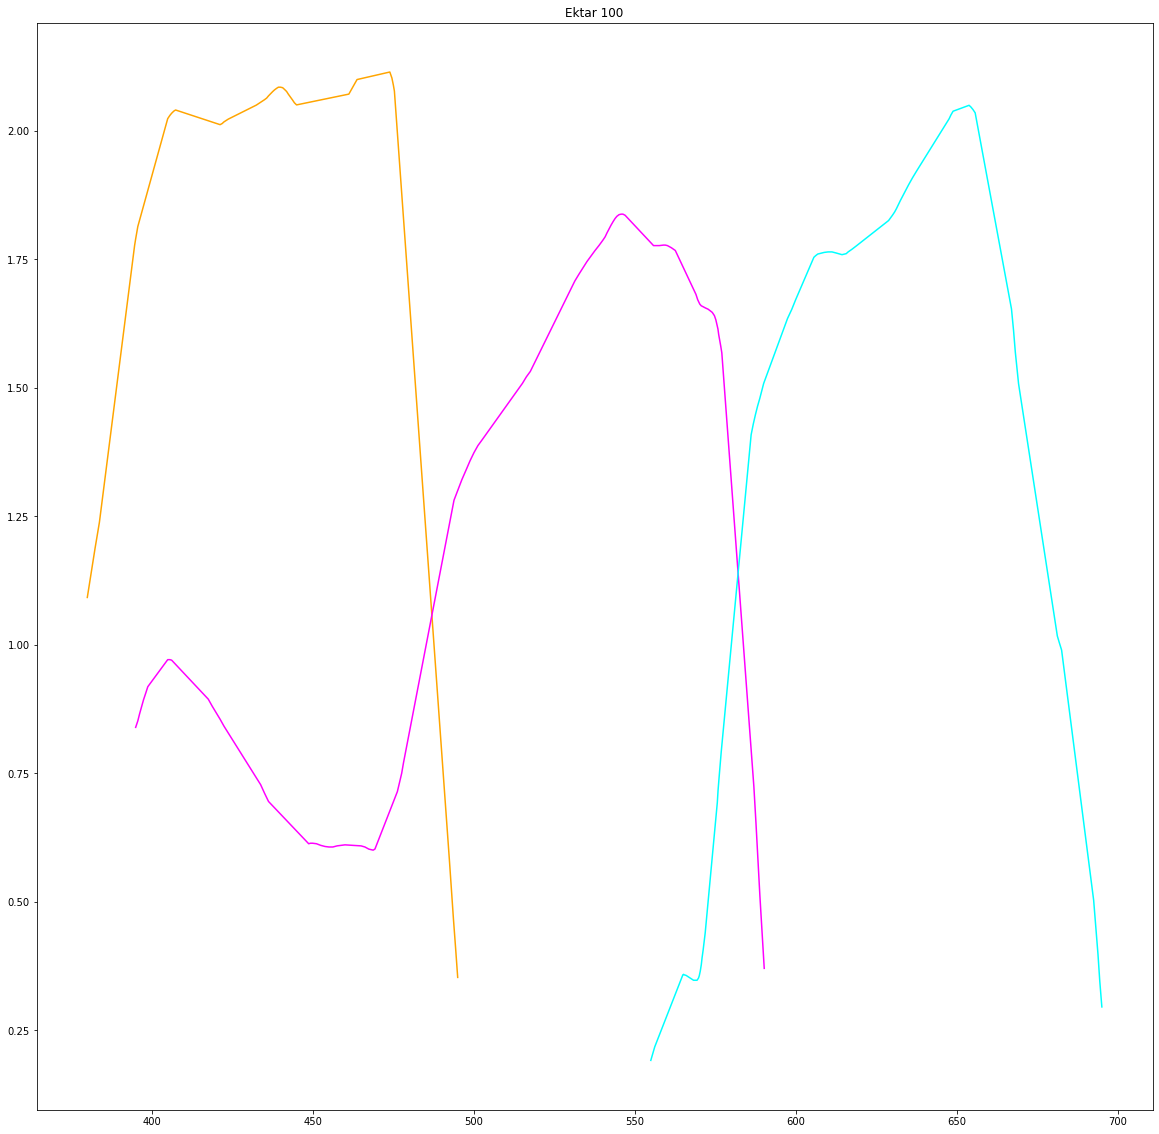

In [6]:
fig, ax = plt.subplots()
ax.set_title("Ektar 100")
ax.plot([p[0] for p in ektar_100.yellow_points], [p[1] for p in ektar_100.yellow_points], color="orange")
ax.plot([p[0] for p in ektar_100.magenta_points], [p[1] for p in ektar_100.magenta_points], color="magenta")
ax.plot([p[0] for p in ektar_100.cyan_points], [p[1] for p in ektar_100.cyan_points], color="cyan")

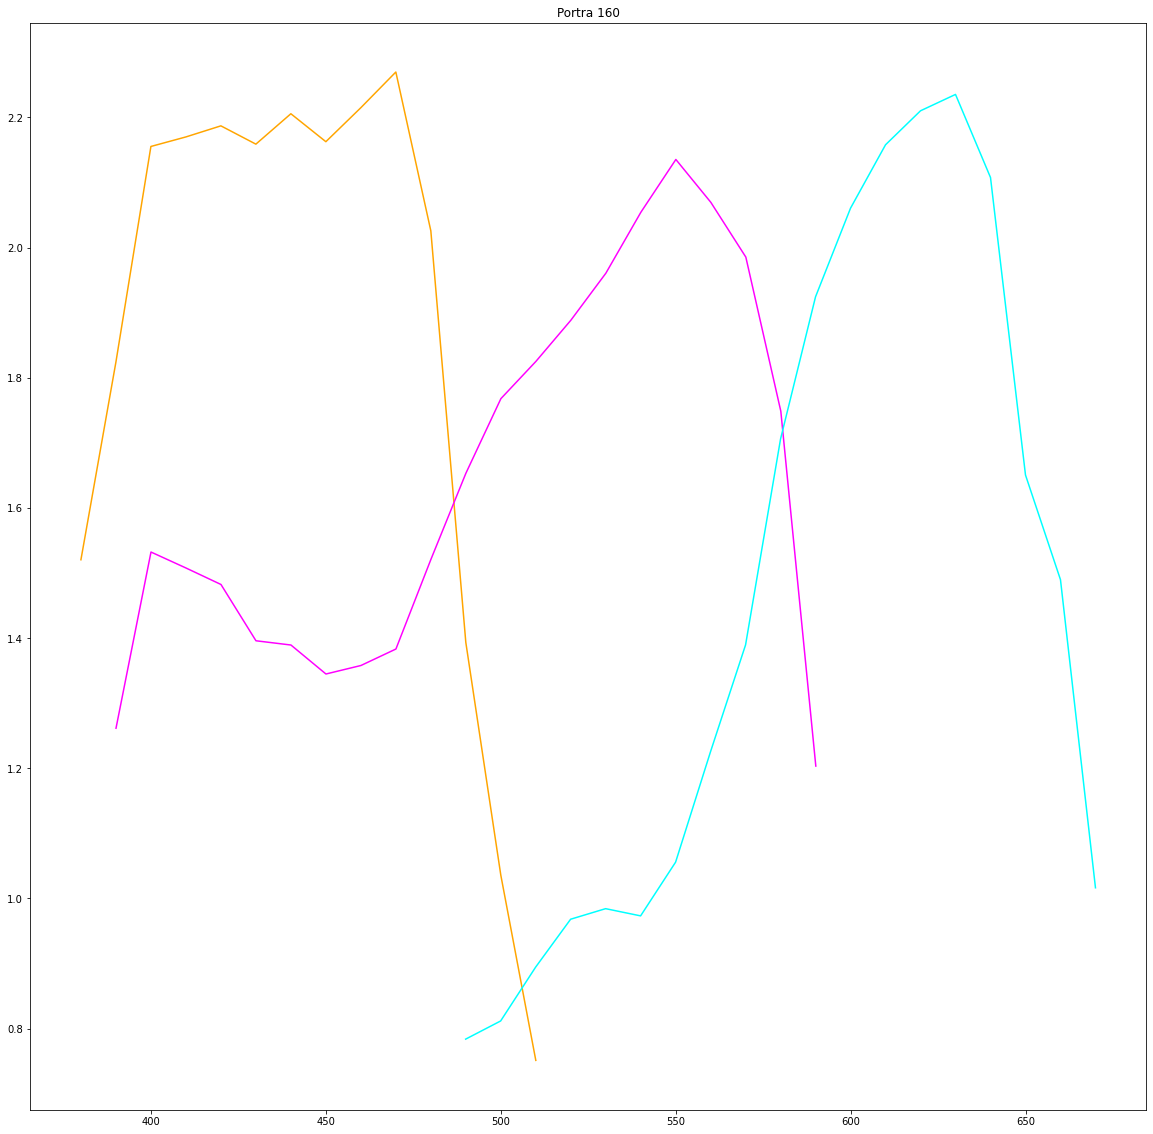

In [7]:
fig, ax = plt.subplots()
ax.set_title("Portra 160")
ax.plot([p[0] for p in portra_160.yellow_points], [p[1] for p in portra_160.yellow_points], color="orange")
ax.plot([p[0] for p in portra_160.magenta_points], [p[1] for p in portra_160.magenta_points], color="magenta")
ax.plot([p[0] for p in portra_160.cyan_points], [p[1] for p in portra_160.cyan_points], color="cyan")

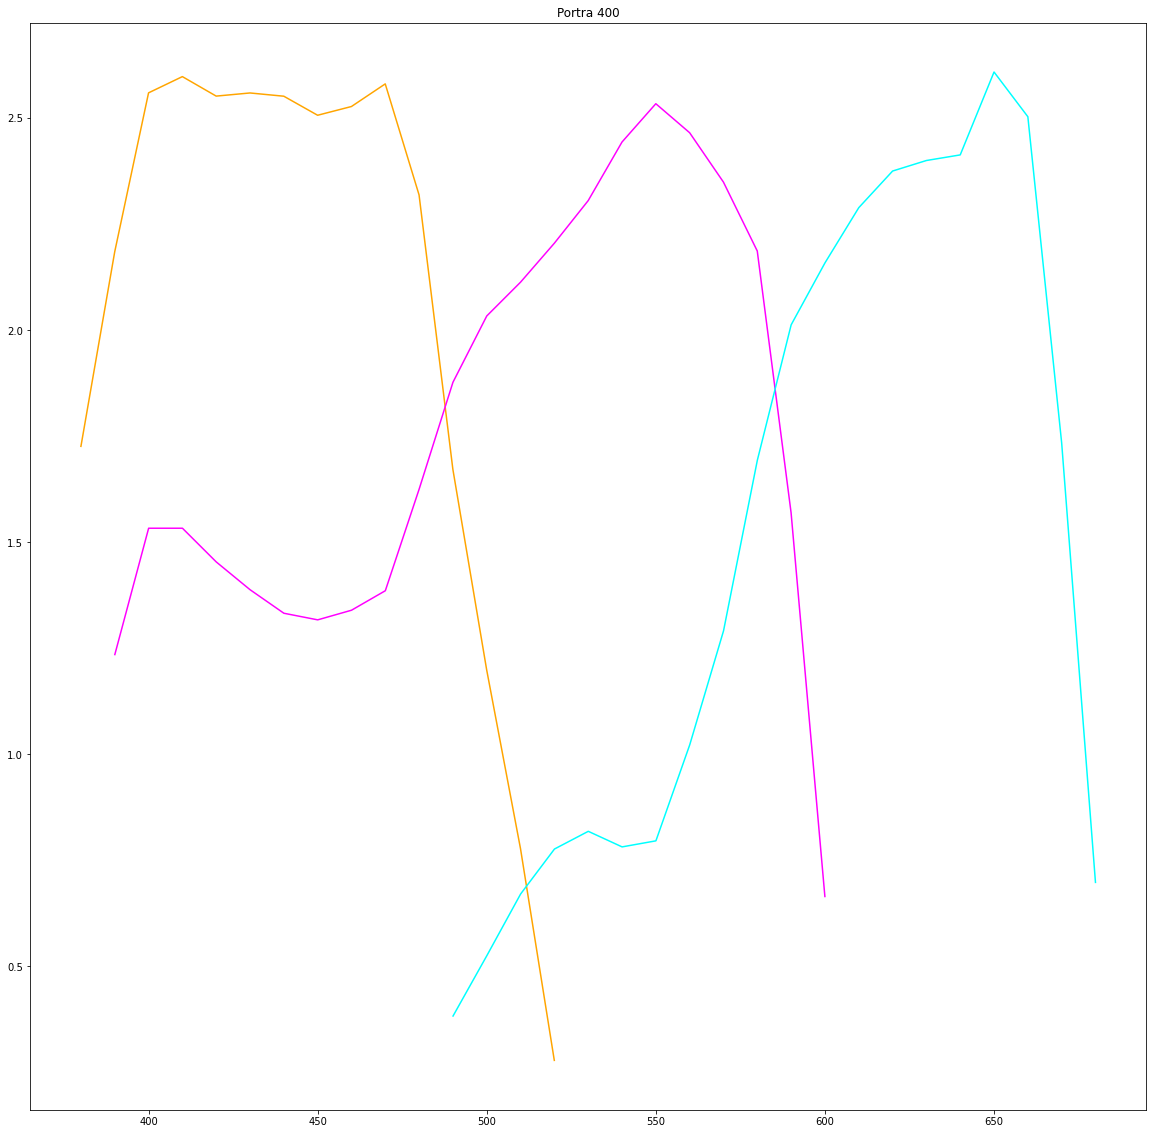

In [8]:
fig, ax = plt.subplots()
ax.set_title("Portra 400")
ax.plot([p[0] for p in portra_400.yellow_points], [p[1] for p in portra_400.yellow_points], color="orange")
ax.plot([p[0] for p in portra_400.magenta_points], [p[1] for p in portra_400.magenta_points], color="magenta")
ax.plot([p[0] for p in portra_400.cyan_points], [p[1] for p in portra_400.cyan_points], color="cyan")

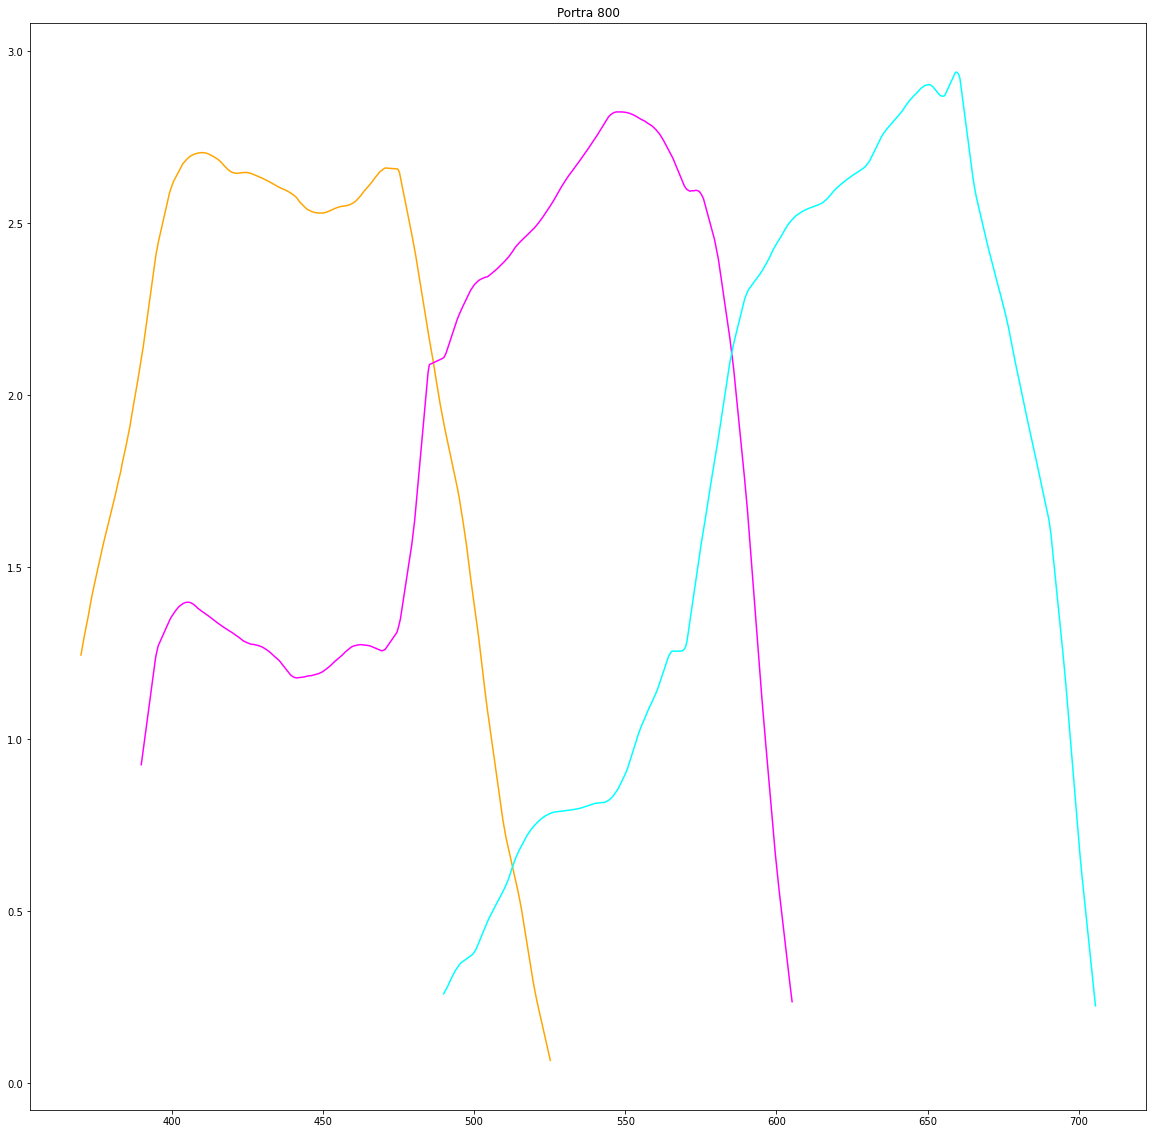

In [9]:
fig, ax = plt.subplots()
ax.set_title("Portra 800")
ax.plot([p[0] for p in portra_800.yellow_points], [p[1] for p in portra_800.yellow_points], color="orange")
ax.plot([p[0] for p in portra_800.magenta_points], [p[1] for p in portra_800.magenta_points], color="magenta")
ax.plot([p[0] for p in portra_800.cyan_points], [p[1] for p in portra_800.cyan_points], color="cyan")

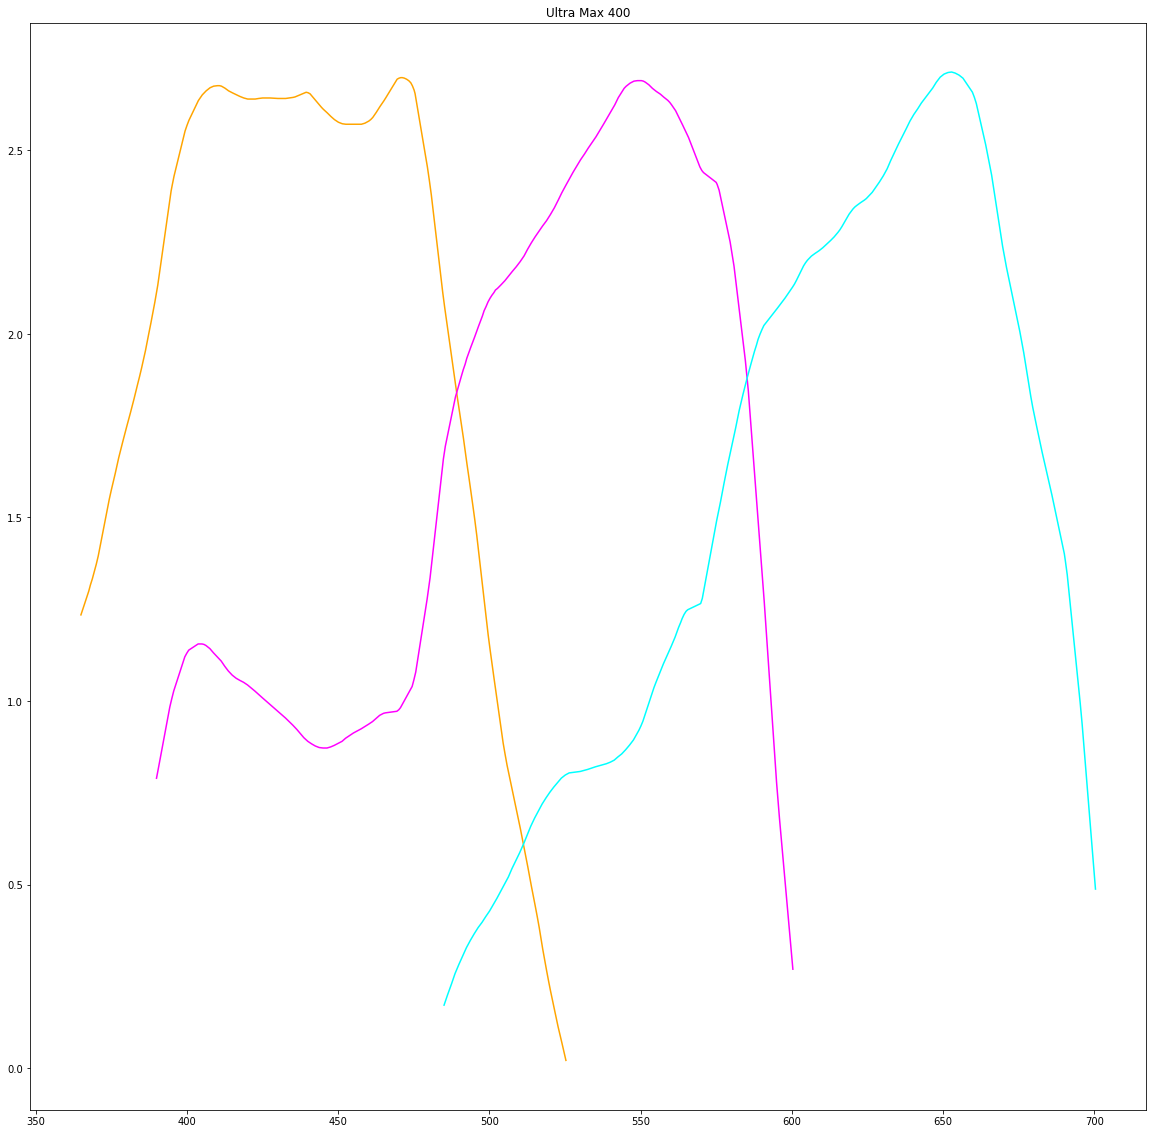

In [10]:
fig, ax = plt.subplots()
ax.set_title("Ultra Max 400")
ax.plot([p[0] for p in ultra_max_400.yellow_points], [p[1] for p in ultra_max_400.yellow_points], color="orange")
ax.plot([p[0] for p in ultra_max_400.magenta_points], [p[1] for p in ultra_max_400.magenta_points], color="magenta")
ax.plot([p[0] for p in ultra_max_400.cyan_points], [p[1] for p in ultra_max_400.cyan_points], color="cyan")

## Writing the data to CSV files

First column is the centre of the wavelength band, the second is the sensitivity as specified in the data sheet.

In [11]:
import os

def write_spectral_sensitivity_csv(filename: str, data: list):
    try:
        os.makedirs(os.path.dirname(filename))
    except OSError:
        pass
    with open(filename, 'w') as csv:
        csv.write("wavelength,sensitivity\n")
        for sample in data:
            csv.write(f"{sample[0]},{sample[1]}\n")

In [12]:
write_spectral_sensitivity_csv("./csv/ektar_100/ektar_100_yellow_forming_layer.csv", ektar_100.yellow_points)
write_spectral_sensitivity_csv("./csv/ektar_100/ektar_100_magenta_forming_layer.csv", ektar_100.magenta_points)
write_spectral_sensitivity_csv("./csv/ektar_100/ektar_100_cyan_forming_layer.csv", ektar_100.cyan_points)

write_spectral_sensitivity_csv("./csv/portra_160/portra_160_yellow_forming_layer.csv", portra_160.yellow_points)
write_spectral_sensitivity_csv("./csv/portra_160/portra_160_magenta_forming_layer.csv", portra_160.magenta_points)
write_spectral_sensitivity_csv("./csv/portra_160/portra_160_cyan_forming_layer.csv", portra_160.cyan_points)

write_spectral_sensitivity_csv("./csv/portra_400/portra_400_yellow_forming_layer.csv", portra_400.yellow_points)
write_spectral_sensitivity_csv("./csv/portra_400/portra_400_magenta_forming_layer.csv", portra_400.magenta_points)
write_spectral_sensitivity_csv("./csv/portra_400/portra_400_cyan_forming_layer.csv", portra_400.cyan_points)

write_spectral_sensitivity_csv("./csv/portra_800/portra_800_yellow_forming_layer.csv", portra_800.yellow_points)
write_spectral_sensitivity_csv("./csv/portra_800/portra_800_magenta_forming_layer.csv", portra_800.magenta_points)
write_spectral_sensitivity_csv("./csv/portra_800/portra_800_cyan_forming_layer.csv", portra_800.cyan_points)

write_spectral_sensitivity_csv("./csv/ultra_max_400/ultra_max_400_yellow_forming_layer.csv", ultra_max_400.yellow_points)
write_spectral_sensitivity_csv("./csv/ultra_max_400/ultra_max_400_magenta_forming_layer.csv", ultra_max_400.magenta_points)
write_spectral_sensitivity_csv("./csv/ultra_max_400/ultra_max_400_cyan_forming_layer.csv", ultra_max_400.cyan_points)